In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import torch.nn.functional as F  # Добавьте этот импорт
import torch.optim as optim
from skimage.transform import resize
from torch.optim import lr_scheduler
from time import time
!pip install torchsummary
from torchsummary import summary
from PIL import Image
import pandas as pd
from tqdm import tqdm

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        target = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, target

def split_train_val(dataframe, test_size=0.1, random_state=42):
    train_df, val_df = train_test_split(dataframe, test_size=test_size, random_state=random_state)
    return train_df, val_df

# Преобразования изображений для обучения и теста
transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),  # Случайный поворот на угол до 30 градусов
    transforms.ColorJitter(contrast=0.5),  # Случайное изменение контрастности
    transforms.ToTensor()
])



In [3]:
def show_images(dataloader, num_images):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axes[idx]
        img = img.permute(1, 2, 0).numpy()  # Перекладываем каналы для отображения
        ax.imshow(img)
        ax.set_title(f'Image {idx+1} - Type {label}')
        ax.axis('off')
    plt.show()

def split_dataset(dataset, val_split=0.1):
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

In [4]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val):
    model.train()
    history = {"epochs": np.arange(epochs) + 1, "train": {"loss": []}, "val": {"loss": [], "rmse": []}}
    
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(data_tr)
        history["train"]["loss"].append(avg_loss)
        
        val_loss, val_rmse = evaluate(model, loss_fn, data_val)
        history["val"]["loss"].append(val_loss)
        history["val"]["rmse"].append(val_rmse)
        
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}')
    
    return history

def evaluate(model, loss_fn, data_loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device).float().unsqueeze(1)
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            total_loss += loss.item()
            all_preds.extend(Y_pred.cpu().numpy())
            all_targets.extend(Y_batch.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    rmse = np.sqrt(avg_loss)  # RMSE calculation
    return avg_loss, rmse

def predict(model, data_loader):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for X_batch in data_loader:
            X_batch = X_batch.to(device)
            Y_pred = model(X_batch)
            all_preds.extend(Y_pred.cpu().numpy())

    return np.array(all_preds).flatten()

In [5]:
# Функция оценки для тестовых данных (без меток)
def evaluate_test(model, data_loader):
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for X_batch in data_loader:
            X_batch = X_batch.to(device)
            Y_pred = model(X_batch)
            all_preds.extend(Y_pred.cpu().numpy().flatten())
    
    return np.array(all_preds)


In [6]:
def scores(model):
    val_loss, val_rmse = evaluate(model, loss_fn, val_loader)
    test_preds = evaluate_test(model, test_loader)
    return val_rmse, test_preds

In [7]:
def make_graph(history, model_name, loss_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history["epochs"], history["train"]["loss"], label="Train Loss")
    plt.plot(history["epochs"], history["val"]["loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel(loss_name)
    plt.title(f"{model_name} Training and Validation Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(history["epochs"], history["val"]["rmse"], label="Validation RMSE")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.title(f"{model_name} Validation RMSE")
    plt.legend()
    plt.show()


In [8]:
def imshow(img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_images(dataloader, num_images=1):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Берем только первые num_images изображений
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for idx in range(num_images):
        ax = axes[idx] if num_images > 1 else axes
        img = images[idx].permute(1, 2, 0)
        ax.imshow(img)
        ax.set_title(f"Label: {labels[idx].item()}")
        ax.axis('off')
    plt.show()

In [9]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Замена последнего слоя на линейный слой с одним выходом
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 40 * 40, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 40 * 40)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print(summary(Net().to(device), (3, 320, 320)))

In [10]:
# Загрузка тренеровочных данных
full_dataset = CustomDataset('/kaggle/input/itmo-2/train_dataset.csv', '/kaggle/input/itmo-2/train_data', transform=transform)

# Разделение на обучающую и валидационную выборки
#train_dataset, val_dataset = split_dataset(full_dataset)

train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



In [11]:
# Загрузка тестовых данных
test_df = pd.read_csv('/kaggle/input/itmo-2/test_dataset.csv')
test_ids = test_df['ID'].values

class TestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

test_dataset = TestDataset(csv_file='/kaggle/input/itmo-2/test_dataset.csv', root_dir='/kaggle/input/itmo-2/test_data', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
# Определение устройства для обучения (GPU, если доступен)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определение модели, функции потерь и оптимизатора
#model = Net().to(device)

loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

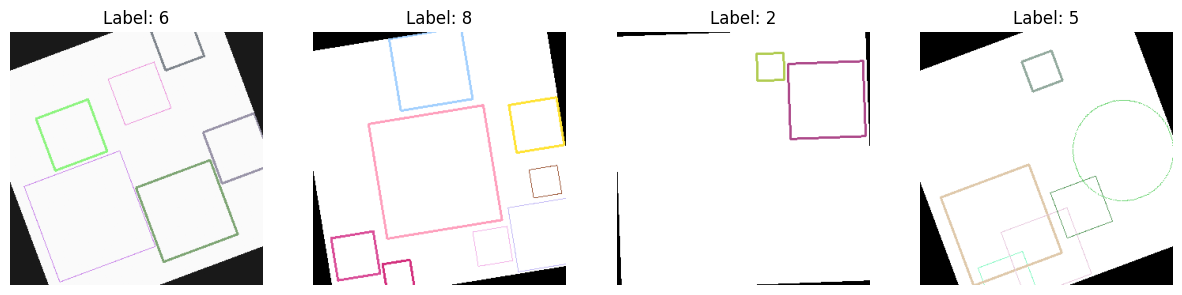

In [13]:
show_images(train_loader, num_images=4)

In [14]:
history = train(model, optimizer, loss_fn, epochs=25, data_tr=train_loader, data_val=val_loader)

Epoch 1/25, Loss: 8.1374, Val Loss: 1.7257, Val RMSE: 1.3137
Epoch 2/25, Loss: 3.0166, Val Loss: 1.8216, Val RMSE: 1.3497
Epoch 3/25, Loss: 1.4516, Val Loss: 1.3796, Val RMSE: 1.1746
Epoch 4/25, Loss: 1.0433, Val Loss: 1.0989, Val RMSE: 1.0483
Epoch 5/25, Loss: 0.9241, Val Loss: 1.5808, Val RMSE: 1.2573
Epoch 6/25, Loss: 0.9280, Val Loss: 1.3693, Val RMSE: 1.1702
Epoch 7/25, Loss: 0.8134, Val Loss: 0.8982, Val RMSE: 0.9477
Epoch 8/25, Loss: 0.7166, Val Loss: 0.9644, Val RMSE: 0.9820
Epoch 9/25, Loss: 0.6817, Val Loss: 0.7913, Val RMSE: 0.8896
Epoch 10/25, Loss: 0.5999, Val Loss: 0.7373, Val RMSE: 0.8586
Epoch 11/25, Loss: 0.5660, Val Loss: 1.4765, Val RMSE: 1.2151
Epoch 12/25, Loss: 0.6502, Val Loss: 0.8997, Val RMSE: 0.9485
Epoch 13/25, Loss: 0.6927, Val Loss: 1.1998, Val RMSE: 1.0953
Epoch 14/25, Loss: 0.5517, Val Loss: 0.7942, Val RMSE: 0.8912
Epoch 15/25, Loss: 0.4596, Val Loss: 1.2669, Val RMSE: 1.1255
Epoch 16/25, Loss: 0.5054, Val Loss: 1.0606, Val RMSE: 1.0298
Epoch 17/25, Loss

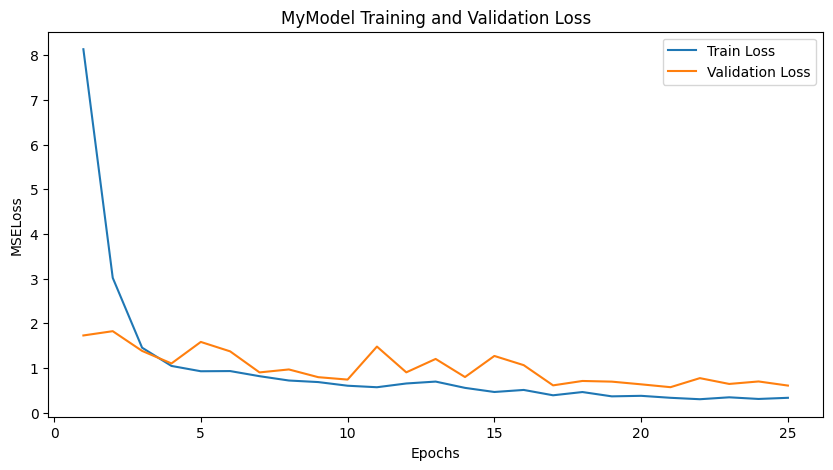

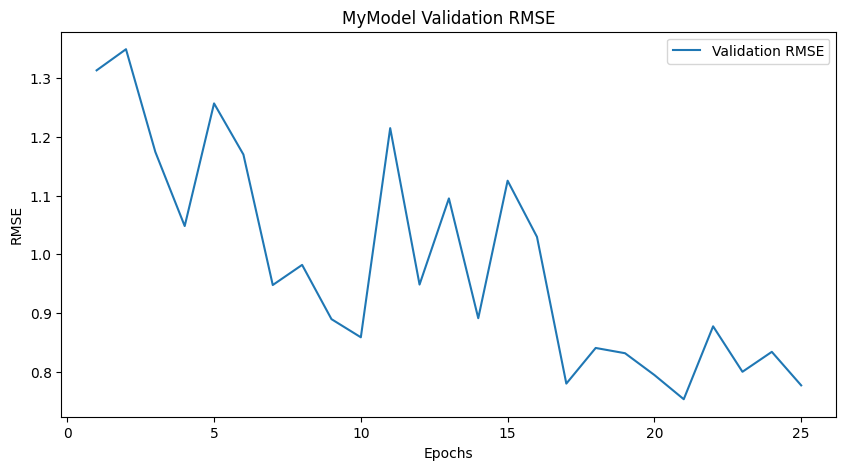

In [15]:
predictions = predict(model, test_loader)
val_score, test_score = scores(model)
make_graph(history, "MyModel", "MSELoss")

In [16]:
# Создание файла сабмита
predictions
predictions = np.round(predictions).astype(int)
submission_df = pd.DataFrame({
    'target': predictions,
    'ID': test_ids
})

In [17]:
submission_df

,target,ID
0,7,1
1,14,2
2,2,3
3,5,4
4,9,5
...,...,...
5995,14,5996
5996,11,5997
5997,13,5998
5998,8,5999


In [18]:
submission_df.to_csv('/kaggle/working/v18res50epochsBatch64.csv', index=False)